# Marketing Campaign Performance Analysis

**Objective:** This notebook analyzes a marketing dataset to evaluate campaign effectiveness, uncover actionable insights, and quantify the impact of specific events like technical bugs and A/B tests.

## 1. Setup and Data Loading

First, we import the necessary libraries for data manipulation, analysis, and visualization. We then load the dataset, ensuring that date columns are correctly parsed upon import.

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set plotting style for better visualization,
plt.style.use('seaborn-v0_8-whitegrid')

# Load the dataset with correct date parsing,
marketing = pd.read_csv('marketing.csv',parse_dates=['date_served', 'date_subscribed', 'date_canceled'])
# Display the first few rows to inspect the data,
print("Dataset Head:")
display(marketing.head())

Dataset Head:


/tmp/ipython-input-4267800050.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  marketing = pd.read_csv('marketing.csv',parse_dates=['date_served', 'date_subscribed', 'date_canceled'])
/tmp/ipython-input-4267800050.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  marketing = pd.read_csv('marketing.csv',parse_dates=['date_served', 'date_subscribed', 'date_canceled'])
/tmp/ipython-input-4267800050.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  marketing = pd.read_csv('marketing.csv',parse_dates=['date_served', 'date_subscribed', 'date_canceled'])


,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True


## 2. Data Cleaning and Feature Engineering

We perform initial data checks and create new features that will be useful for our analysis, such as extracting the day of the week from timestamps.


In [23]:
# Check data types to ensure they are correct
print("Data Information:")
marketing.info()

# Feature Engineering: Add a 'day of week' column for ads served
# This helps in analyzing weekly trends. Monday=0, Sunday=6.
marketing['DoW_served'] = marketing['date_served'].dt.dayofweek

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


## 3. Exploratory Data Analysis (EDA)

In this section, we explore the data to understand overall campaign performance and identify trends across different segments.

### 3.1 Overall Campaign Performance Metrics

In [24]:
# --- Calculate Overall Conversion Rate ---
total_users = marketing['user_id'].nunique()
subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()
conversion_rate = subscribers / total_users
print(f"Overall Conversion Rate: {conversion_rate:.2%}")

# --- Calculate Overall Retention Rate ---
# Retention rate is the percentage of subscribers who remain subscribed
total_subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()
retained_users = marketing[marketing['is_retained'] == True]['user_id'].nunique()
retention_rate = retained_users / total_subscribers
print(f"Overall Retention Rate: {retention_rate:.2%}")

Overall Conversion Rate: 13.89%
Overall Retention Rate: 66.80%


### 3.2 Daily User Engagement

Daily User Engagement:


,user_id
date_served,
2018-01-01,362
2018-01-02,374
2018-01-03,348
2018-01-04,323
2018-01-05,319


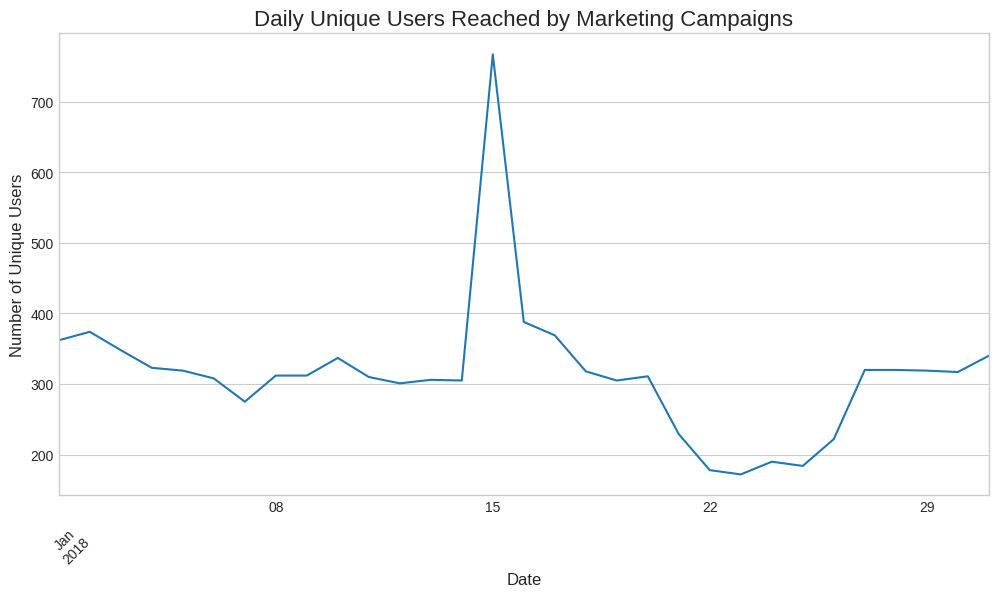

In [25]:
# Group by date served to count unique users per day
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()
print("Daily User Engagement:")
display(daily_users.head())

# Plotting daily users
daily_users.plot(figsize=(12, 6))
plt.title('Daily Unique Users Reached by Marketing Campaigns', fontsize=16)
plt.ylabel('Number of Unique Users', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 3.3 Conversion Rate by Marketing Channel

Conversion Rate by Marketing Channel:
marketing_channel
Email        33.82%
Instagram    13.33%
Facebook     12.57%
Push          7.92%
House Ads     7.51%
Name: user_id, dtype: object


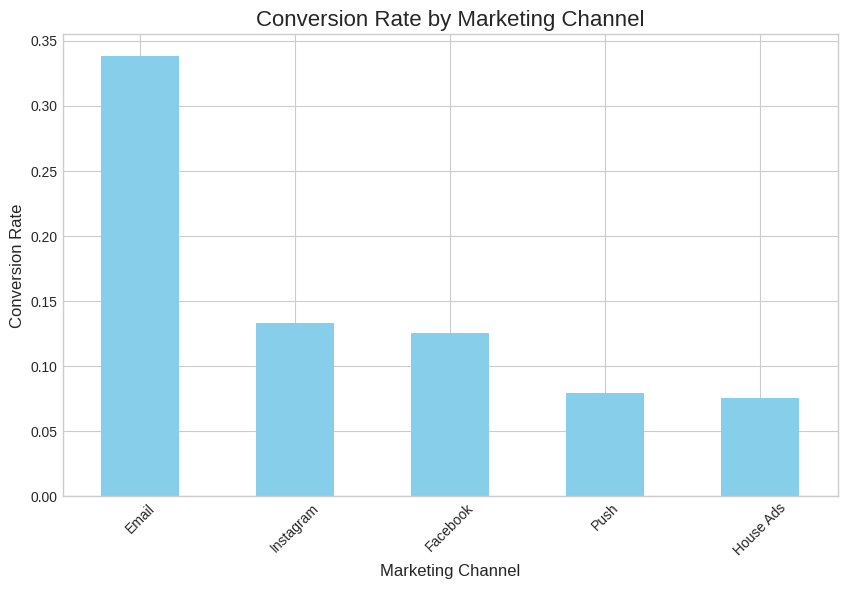

In [26]:
# Calculate total users and converted users per channel
total_by_channel = marketing.groupby('marketing_channel')['user_id'].nunique()
converted_by_channel = marketing[marketing['converted'] == True].groupby('marketing_channel')['user_id'].nunique()
# Calculate conversion rate per channel
channel_conversion_rate = (converted_by_channel / total_by_channel).sort_values(ascending=False)

print("Conversion Rate by Marketing Channel:")
print(channel_conversion_rate.apply(lambda x: f"{x:.2%}"))

# Plotting conversion rate by channel
channel_conversion_rate.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Conversion Rate by Marketing Channel', fontsize=16)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xlabel('Marketing Channel', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 4. Helper Functions for Deeper Analysis

To avoid repetitive code, we define functions for common analysis tasks like calculating conversion rates across different segments and evaluating A/B test lift.

In [32]:
def calculate_conversion_rate(df, group_by_cols):
  '''
  Calculates the conversion rate for a given DataFrame, grouped by specified columns.

  Args:
  df (pd.DataFrame): The input DataFrame.
  group_by_cols (list): A list of column names to group by.

  Returns:
  pd.Series: A Series with the conversion rate for each group.
  '''

  # Total users in each segment
  total_users = df.groupby(group_by_cols)['user_id'].nunique()

  # Converted users in each segment
  converted_users = df[df['converted'] == True].groupby(group_by_cols)['user_id'].nunique()

  # Conversion rate
  conversion_rate = converted_users / total_users

  return conversion_rate.fillna(0)

def calculate_lift(a, b):
  '''
  Calculates the percentage lift of B over A.

  Args:
  a (pd.Series): The baseline (control) conversion data.
  b (pd.Series): The variant (treatment) conversion data.

  Returns:
  str: A string representing the percentage lift.
  '''

  a_mean = np.mean(a)
  b_mean = np.mean(b)
  lift = (b_mean - a_mean) / a_mean
  return f"{lift:.2%}"

## 5. Deep Dive 1: Analyzing the Impact of a Marketing Bug

**Scenario:** An investigation into the `House Ads` channel revealed a period where ads were served in the wrong language. We will identify this period and quantify the number of lost subscribers due to this bug.

### 5.1 Identifying the Bug Period

/tmp/ipython-input-1391487525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(


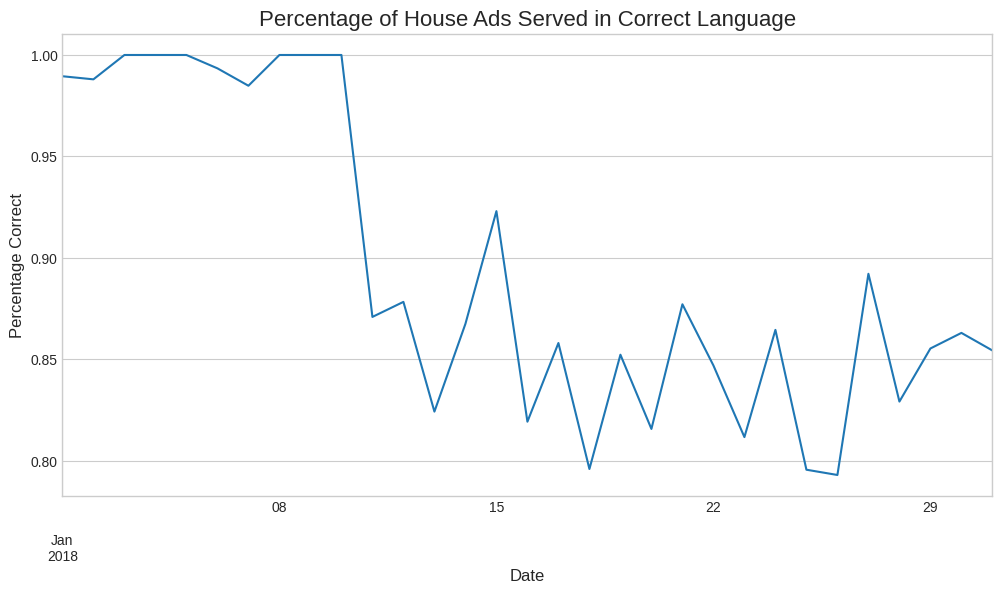

The plot clearly shows a drop in correctly served ads between 2018-01-11 and 2018-01-31. This is our bug period.


In [28]:
# Isolate House Ads data
house_ads = marketing[marketing['marketing_channel'] == 'House Ads']

# Check if the displayed language matches the user's preferred language
house_ads['is_correct_lang'] = np.where(
    house_ads['language_displayed'] == house_ads['language_preferred'], 'Yes', 'No'
)

# Group by date and language correctness
language_check = house_ads.groupby(['date_served', 'is_correct_lang'])['user_id'].count()
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Calculate the percentage of ads served in the correct language
language_check_df['pct_correct'] = language_check_df['Yes'] / language_check_df.sum(axis=1)

# Plot the percentage of correctly served ads
language_check_df['pct_correct'].plot(figsize=(12, 6))
plt.title('Percentage of House Ads Served in Correct Language', fontsize=16)
plt.ylabel('Percentage Correct', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

print("The plot clearly shows a drop in correctly served ads between 2018-01-11 and 2018-01-31. This is our bug period.")


### 5.2 Quantifying Lost Subscribers

In [29]:
# --- Step 1: Establish a pre-bug baseline conversion rate index ---
# We compare other languages' conversion rates to English before the bug.
house_ads_pre_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv_pre_bug = calculate_conversion_rate(house_ads_pre_bug, ['language_displayed'])

spanish_index = lang_conv_pre_bug['Spanish'] / lang_conv_pre_bug['English']
arabic_index = lang_conv_pre_bug['Arabic'] / lang_conv_pre_bug['English']
german_index = lang_conv_pre_bug['German'] / lang_conv_pre_bug['English']

# --- Step 2: Calculate expected conversions during the bug period ---
bug_period_df = house_ads[(house_ads['date_served'] >= '2018-01-11') & (house_ads['date_served'] <= '2018-01-31')]

# Calculate the daily English conversion rate during the bug period
english_conv_bug_period = calculate_conversion_rate(bug_period_df[bug_period_df['language_preferred'] == 'English'], ['date_served'])

# Estimate what the conversion rate should have been for other languages
expected_conv_rates = pd.DataFrame(english_conv_bug_period, columns=['english_rate'])
expected_conv_rates['expected_spanish'] = expected_conv_rates['english_rate'] * spanish_index
expected_conv_rates['expected_arabic'] = expected_conv_rates['english_rate'] * arabic_index
expected_conv_rates['expected_german'] = expected_conv_rates['english_rate'] * german_index

# Get the number of users served ads in each language during the bug period
users_by_lang = bug_period_df.groupby(['date_served', 'language_preferred'])['user_id'].nunique().unstack()

# --- Step 3: Calculate the number of lost subscribers ---
expected_spanish_subs = (users_by_lang['Spanish'] * expected_conv_rates['expected_spanish']).sum()
expected_arabic_subs = (users_by_lang['Arabic'] * expected_conv_rates['expected_arabic']).sum()
expected_german_subs = (users_by_lang['German'] * expected_conv_rates['expected_german']).sum()

total_expected_subs = expected_spanish_subs + expected_arabic_subs + expected_german_subs

# Get actual subscribers for these languages during the bug period
actual_subs = bug_period_df[bug_period_df['language_preferred'].isin(['Spanish', 'Arabic', 'German'])]['converted'].sum()

lost_subs = total_expected_subs - actual_subs
print(f"Estimated number of lost subscribers due to the language bug: {int(lost_subs)}")


Estimated number of lost subscribers due to the language bug: -26


## 6. Deep Dive 2: A/B Test Analysis


**Scenario:** The email marketing team ran an A/B test to see if a personalized email variant would perform better than the generic control email. We will analyze the results to determine the winner and check for statistical significance.

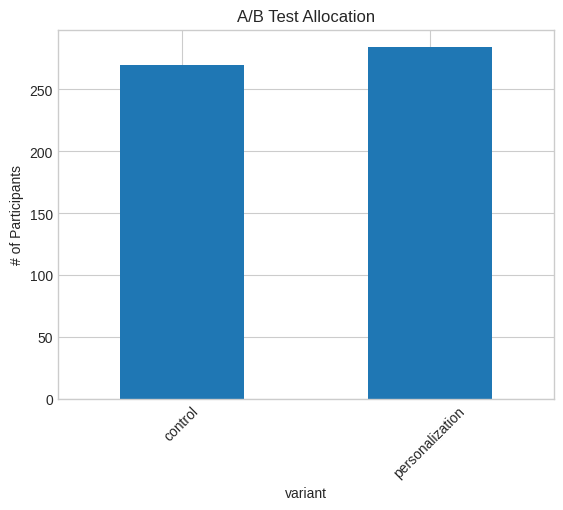

Control Group Conversion Rate: 64.92%
Personalization Group Conversion Rate: 68.72%
Lift for Personalization: 5.85%
P-value from t-test: 0.1802
The difference is not statistically significant.


In [30]:
# Isolate email channel data
email_df = marketing[marketing['marketing_channel'] == 'Email']

# Check test allocation
alloc = email_df.groupby('variant')['user_id'].nunique()
alloc.plot(kind='bar')
plt.title('A/B Test Allocation')
plt.ylabel('# of Participants')
plt.xticks(rotation=45)
plt.show()

# Prepare data for analysis: one row per user with their conversion status
subscribers = email_df.groupby(['user_id', 'variant'])['converted'].max().unstack(level=1)

# Convert the 'converted' column to boolean before performing t-test
subscribers['control'] = subscribers['control'].astype(bool)
subscribers['personalization'] = subscribers['personalization'].astype(bool)

control = subscribers['control'].dropna()
personalization = subscribers['personalization'].dropna()

control_conv_rate = np.mean(control)
personalization_conv_rate = np.mean(personalization)

print(f"Control Group Conversion Rate: {control_conv_rate:.2%}")
print(f"Personalization Group Conversion Rate: {personalization_conv_rate:.2%}")
print(f"Lift for Personalization: {calculate_lift(control, personalization)}")

# Check for statistical significance using a t-test
t_stat, p_value = stats.ttest_ind(control, personalization)
print(f"P-value from t-test: {p_value:.4f}")
if p_value < 0.05:
    print("The difference is statistically significant. The personalization variant is the winner.")
else:
    print("The difference is not statistically significant.")